In [2]:
import sys
sys.path.append('/Users/apple/Desktop/learningfor3Dvision/asg1/assignment1/')
from starter.utils import get_points_renderer, unproject_depth_image
from starter.render_generic import load_rgbd_data
import pytorch3d
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import imageio


In [3]:
points_renderer = get_points_renderer(
    image_size=256,
    radius=0.01,
)

In [4]:
data = load_rgbd_data("/Users/apple/Desktop/learningfor3Dvision/asg1/assignment1/data/rgbd_data.pkl")

In [5]:
points1, rgb1 = unproject_depth_image(torch.Tensor(data["rgb1"]), 
                                torch.Tensor(data["mask1"]), 
                                torch.Tensor(data["depth1"]), 
                                data["cameras1"])
points1=points1.unsqueeze(0)
rgb1=rgb1.unsqueeze(0)

/usr/local/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
point_cloud_1 = pytorch3d.structures.Pointclouds(
    points=points1, features=rgb1
).to(device)

In [23]:
points2, rgb2 = unproject_depth_image(torch.Tensor(data["rgb2"]), 
                                torch.Tensor(data["mask2"]), 
                                torch.Tensor(data["depth2"]), 
                                data["cameras2"])
points2=points2.unsqueeze(0)
rgb2=rgb2.unsqueeze(0)

In [24]:
point_cloud_2 = pytorch3d.structures.Pointclouds(
    points=points2, features=rgb2
).to(device)

In [25]:
print(points1.size(), points2.size())
print(rgb1.size(), rgb2.size())

torch.Size([1, 125035, 3]) torch.Size([1, 123749, 3])
torch.Size([1, 125035, 4]) torch.Size([1, 123749, 4])


In [26]:
points2_mod = points2.clone()
rgb2_mod = rgb2.clone()
points2_mod = points2_mod.resize_(*points1.size())
rgb2_mod=rgb2_mod.resize_(*rgb1.size())

In [27]:
print(points1.size(), points2.size())
print(rgb1.size(), rgb2.size())

torch.Size([1, 125035, 3]) torch.Size([1, 123749, 3])
torch.Size([1, 125035, 4]) torch.Size([1, 123749, 4])


In [28]:
torch.cat((points1,points2_mod), 0).shape[2]

3

In [31]:
point_cloud_3 = pytorch3d.structures.Pointclouds(
    points=torch.cat((points1,points2_mod), 0),
    features=torch.cat((rgb1,rgb2_mod), 0)
).to(device)

In [32]:
# R0 = torch.tensor([[1.0,0.,0.], [0.0,1.0,0.0],[0.0,0.0,1.0]])
pc_R, pc_T = pytorch3d.renderer.look_at_view_transform(
    dist=6,
    elev=0,
    azim=np.linspace(-180, 180, 5, endpoint=False),
)
pc_cameras = pytorch3d.renderer.FoVPerspectiveCameras(
    R=pc_R,
    T=pc_T,
    device=device)
   

In [33]:
lights = pytorch3d.renderer.PointLights(location=[[0, 0, -4]], device=device)

In [34]:
images1 = []
for i in range(5):
    camera = pytorch3d.renderer.FoVPerspectiveCameras(
        R=pc_R[i:i+1], T=pc_T[i:i+1], device=device
    )
    image = points_renderer(point_cloud_1, cameras=camera, lights=lights)
    images1.append(image)

In [35]:
images_rgb1=[]
for image in images1:
    images_rgb1.append(image.squeeze(0))
images_rgb_uint8_1 = [(img * 255).numpy().astype('uint8') for img in images_rgb1]

In [36]:
imageio.mimsave("/Users/apple/Desktop/learningfor3Dvision/asg1/assignment1/pointcloud/plant1.gif", images_rgb_uint8_1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


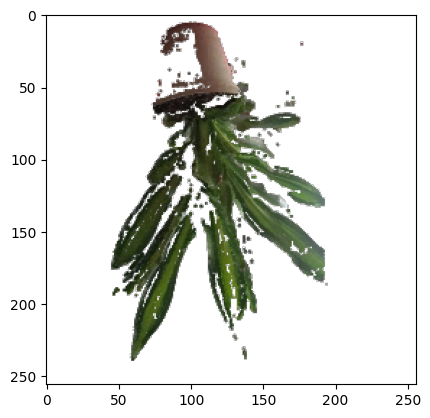

In [37]:
plt.imshow(images1[4].squeeze(0))

In [38]:
images2 = []
for i in range(5):
    camera = pytorch3d.renderer.FoVPerspectiveCameras(
        R=pc_R[i:i+1], T=pc_T[i:i+1], device=device
    )
    image = points_renderer(point_cloud_2, cameras=camera, lights=lights)
    images2.append(image)

In [39]:
images_rgb2=[]
for image in images1:
    images_rgb2.append(image.squeeze(0))
images_rgb_uint8_2 = [(img * 255).numpy().astype('uint8') for img in images_rgb2]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


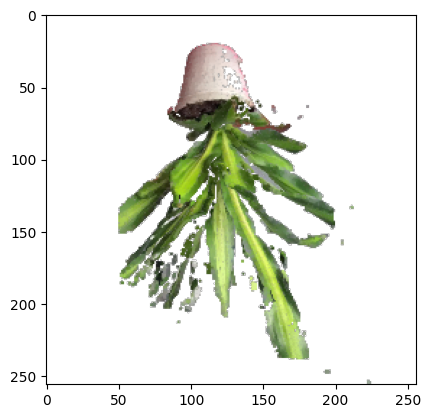

In [40]:
plt.imshow(images2[0].squeeze(0))

In [41]:
images1[0].squeeze(0).shape

torch.Size([256, 256, 4])

In [42]:
images3 = []
for i in range(5):
    camera = pytorch3d.renderer.FoVPerspectiveCameras(
        R=pc_R[i:i+1], T=pc_T[i:i+1], device=device
    )
    image = points_renderer(point_cloud_3
, cameras=camera, lights=lights)
    images3.append(image)

In [43]:
images_rgb3=[]
for image in images3:
    images_rgb3.append(image.squeeze(0))
images_rgb_uint8_3 = [(img * 255).numpy().astype('uint8') for img in images_rgb3]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


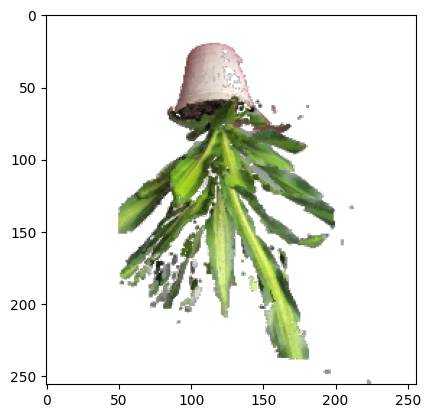

In [44]:
plt.imshow(images3[0].squeeze(0)[-1,:,:,:])

In [47]:
num_samples=100
phi = torch.linspace(0, 2 * np.pi, num_samples)
theta = torch.linspace(0, np.pi, num_samples)
# Densely sample phi and theta on a grid
Phi, Theta = torch.meshgrid(phi, theta)

x = torch.sin(Theta) * torch.cos(Phi)
y = torch.cos(Theta)
z = torch.sin(Theta) * torch.sin(Phi)

points = torch.stack((x.flatten(), y.flatten(), z.flatten()), dim=1)
color = (points - points.min()) / (points.max() - points.min())

sphere_point_cloud = pytorch3d.structures.Pointclouds(
    points=points.unsqueeze(0), features=color.unsqueeze(0),
).to(device)

cameras = pytorch3d.renderer.FoVPerspectiveCameras(T=[[0, 0, 3]], device=device)
renderer = get_points_renderer(image_size=256, device=device)
rend = renderer(sphere_point_cloud, cameras=cameras)

In [46]:
points.shape

torch.Size([10000, 3])

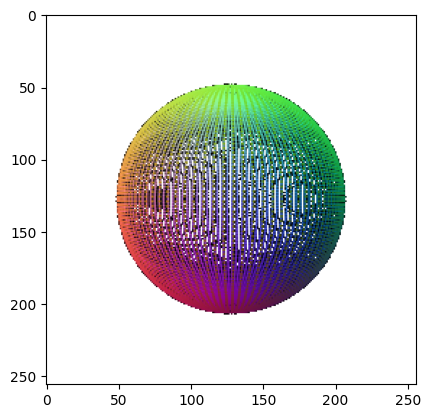

In [49]:
plt.imshow(rend.squeeze(0))

In [84]:
Rot,T = pytorch3d.renderer.cameras.look_at_view_transform(
    dist = 5,
    elev = -30,
    azim = 0
)

In [85]:
num_samples=100
phi = torch.linspace(0, 2 * np.pi, num_samples)
theta = torch.linspace(0, np.pi, num_samples)
# Densely sample phi and theta on a grid
Phi, Theta = torch.meshgrid(phi, theta)
R=2.0
r=0.5

x = torch.cos(Phi)*(R+(r*torch.cos(Theta)))
y = torch.sin(Phi)*(R+(r*torch.cos(Theta)))
z = torch.sin(Theta) * r

points = torch.stack((x.flatten(), y.flatten(), z.flatten()), dim=1)
color = (points - points.min()) / (points.max() - points.min())

sphere_point_cloud = pytorch3d.structures.Pointclouds(
    points=points.unsqueeze(0), features=color.unsqueeze(0),
).to(device)

cameras = pytorch3d.renderer.FoVPerspectiveCameras(R=Rot, T=T, device=device)
renderer = get_points_renderer(image_size=256, device=device)
rend = renderer(sphere_point_cloud, cameras=cameras)

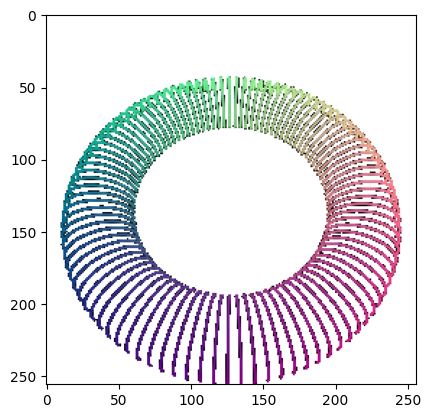

In [86]:
plt.imshow(rend.squeeze(0))